In [1]:
from config.query import BigQueryClient
from config.config import TABLES

In [2]:
bq = BigQueryClient()

In [3]:
A = bq.get_dataframe(TABLES['A'])

In [4]:
import ast

# Convert string representations of dictionaries to actual dictionaries, then sum their values
A['totalTvls'] = A['currentChainTvls'].apply(lambda x: sum(ast.literal_eval(x).values()) if isinstance(x, str) and x.strip() != '' else 0)

# Sort A by 'totalTvls', descending
A = A.sort_values(by='totalTvls', ascending=False)

In [5]:
query = f"SELECT DISTINCT token_name FROM `{bq.dataset_ref.dataset_id}.{TABLES['C']}`"

unique_token_names = bq.client.query(query).to_dataframe()

# establish mapping
- rev_map
    - this is the easiest case, we can just use the coin id from the mapping
- LP
    - need to think more, might need to consider bridge
- UNKNOWN
    - a common cell here is UNKNOWN (heco:0x5eE41aB6edd38cDfB9f6B4e6Cf7F75c87E170d98)
    - this follows UNKNOWN (X:Y)
    - the X:Y mapping identifies Y as the search source, we utilize Y to find the protocol id
- Other
    - major custodial protocols, need to be handled manually


In [73]:
query = f"""
SELECT token_name, COUNT(*) as frequency
FROM `{bq.dataset_ref.dataset_id}.{TABLES['C']}`
GROUP BY token_name
ORDER BY frequency DESC
"""

# Execute the query and retrieve the DataFrame
frequency_df = bq.client.query(query).to_dataframe()

handle MAP

In [6]:
import json
import pandas as pd

rev_map = {}

for idx, row in A.iterrows():
    if pd.notna(row['assetToken']) and row['assetToken'] != "-":
        rev_map[row['assetToken']] = row['id']
    if pd.notna(row['symbol']) and row['symbol'] != "-":
        rev_map[row['symbol']] = row['id']

with open('config/rev_map.json', 'w') as json_file:
    # Use json.dump() to write the rev_map dictionary to the file
    json.dump(rev_map, json_file, indent=4)

In [81]:
frequency_dict = frequency_df.set_index('token_name')['frequency'].to_dict()

categories = {'MAP': {}, 'LP': {}, 'UNKNOWN': {}, 'PRIMARY': {}, 'OTHER': {}}

for index, row in unique_token_names.iterrows():
    token_name = row['token_name']
    category = 'OTHER'
    if token_name in rev_map:
        category = 'MAP'
    elif "LP" in token_name:
        category = 'LP'
    elif "UNKNOWN" in token_name:
        category = 'UNKNOWN'
    elif "-" in token_name:
        category = 'OTHER'
    else:
        category = 'PRIMARY'
    # Include frequency along with id in the dictionary
    categories[category][token_name] = {
        'id': rev_map.get(token_name, None),
        'frequency': frequency_dict.get(token_name, 0)  # Default to 0 if not found
    }

handle LP

In [83]:
categories['LP']

{'2SHARES-WFTM-SPLP': {'id': None, 'frequency': 11536},
 'AXIAL-WAVAX-JLP': {'id': None, 'frequency': 4662},
 'WBNB-USDT-CAKE-LP': {'id': None, 'frequency': 12834},
 'WBNB-DUEL-CAKE-LP': {'id': None, 'frequency': 11344},
 'WFTM-YOSHI-SPIRIT-LP': {'id': None, 'frequency': 5448},
 'PTESTLP': {'id': None, 'frequency': 5448},
 'BSHARE-WFTM-SPLP': {'id': None, 'frequency': 5448},
 'TUSD-BUSD-BSW-LP': {'id': None, 'frequency': 21926},
 'LPOOL': {'id': None, 'frequency': 17370},
 'WBNB-PALM-CAKE-LP': {'id': None, 'frequency': 4986},
 'STSOL-WSOL-SABER-LP': {'id': None, 'frequency': 4402},
 'WSOL-ZSOL-SABER-LP': {'id': None, 'frequency': 1400},
 'CRV-WETH-SLP': {'id': None, 'frequency': 1734},
 'RARI-WETH-SLP': {'id': None, 'frequency': 1734},
 'BUSD-ALPACA-CAKE-LP': {'id': None, 'frequency': 8170},
 'WFTM-KNGFUU-SPLP': {'id': None, 'frequency': 1070},
 'ANY-WFTM-SPLP': {'id': None, 'frequency': 11860},
 'WAVAX-FEED-JLP': {'id': None, 'frequency': 5584},
 'WPLS-PLSX-PLP': {'id': None, 'frequen

handle UNKNOWN

In [76]:
categories['UNKNOWN']

{'UNKNOWN (avax:0x3eab2111dFc8DbEe0e1e1F0b4F3eAA99523f9E2e)': {'id': None,
  'frequency': 1572},
 'UNKNOWN (avax:0xE9476e16FE488B90ada9Ab5C7c2ADa81014Ba9Ee)': {'id': None,
  'frequency': 1572},
 'UNKNOWN (harmony:0x26b4145303da37a3fbabe8ff7696c7d5510207bb)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0x9f6d97dd4f57b139a9c516a222fc78da751226cf)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xd6ca29f43ece5e5367b2147655b76310cbeb66c3)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xcffa951d31cec708bd33272bc2cd7ac5af72a26e)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0xa71ebb88d300d4ab9fd16e8c587a2799b0f0e71f)': {'id': None,
  'frequency': 13202},
 'UNKNOWN (harmony:0x39927a2cee5580d63a163bc402946c7600300373)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (harmony:0x600541ad6ce0a8b5dae68f086d46361534d20e80)': {'id': None,
  'frequency': 7880},
 'UNKNOWN (fantom:0x68f7880f7af43a81bef25e2ae83802eb6c2ddbfd)': {'id': None,
  'frequency': 5448},
 'UNKN

handle OTHER

In [84]:
categories['OTHER']

{'KT1UsSfaXyqcjSVPeiD7U1bWgKy3taYN7NWY-8': {'id': None, 'frequency': 982},
 'KT1AFq5XorPduoYyWxs5gEyrFK6fVjJVbtCj-4538': {'id': None, 'frequency': 982},
 'WAVAX-ORCA-PGL': {'id': None, 'frequency': 10246},
 'WAVAX-UST-PGL': {'id': None, 'frequency': 10246},
 'BUSD3CRV-F': {'id': None, 'frequency': 10264},
 'REALTOKEN-S-8056-E-HOLLYWOOD-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-5278-5280-DREXEL-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-4456-FAIRVIEW-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALT-S-9309-COURVILLE-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALT-S-9133-DEVONSHIRE-RD-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-10862-MARNE-ST-DETROIT-MI': {'id': None, 'frequency': 5352},
 'REALTOKEN-S-18286-OAKFIELD-AVE-DETROIT-MI': {'id': None, 'frequency': 5352},
 'GUSDFRAXBP3CRV-F': {'id': None, 'frequency': 8820},
 'ACRV-F': {'id': None, 'frequency': 10720},
 'WETH-CEL-UNI-V2': {'id': None, 'frequency': 2036},
 

In [67]:
# Initialize two lists to hold tokens with and without hyphens
tokens_with_hyphen = []
tokens_without_hyphen = []

# Iterate through the tokens in the 'Other' category
for token_name in categories["OTHER"]:
    if '-' in token_name:
        tokens_with_hyphen.append(token_name)
    else:
        tokens_without_hyphen.append(token_name)

# Analysis results
print(f"Total tokens in 'Other': {len(categories['OTHER'])}")
print(f"Tokens with hyphen: {len(tokens_with_hyphen)}")
print(f"Tokens without hyphen: {len(tokens_without_hyphen)}")

Total tokens in 'Other': 9814
Tokens with hyphen: 1957
Tokens without hyphen: 7857


analysis

In [79]:
import matplotx
import matplotlib.pyplot as plt
plt.style.use(matplotx.styles.dracula)

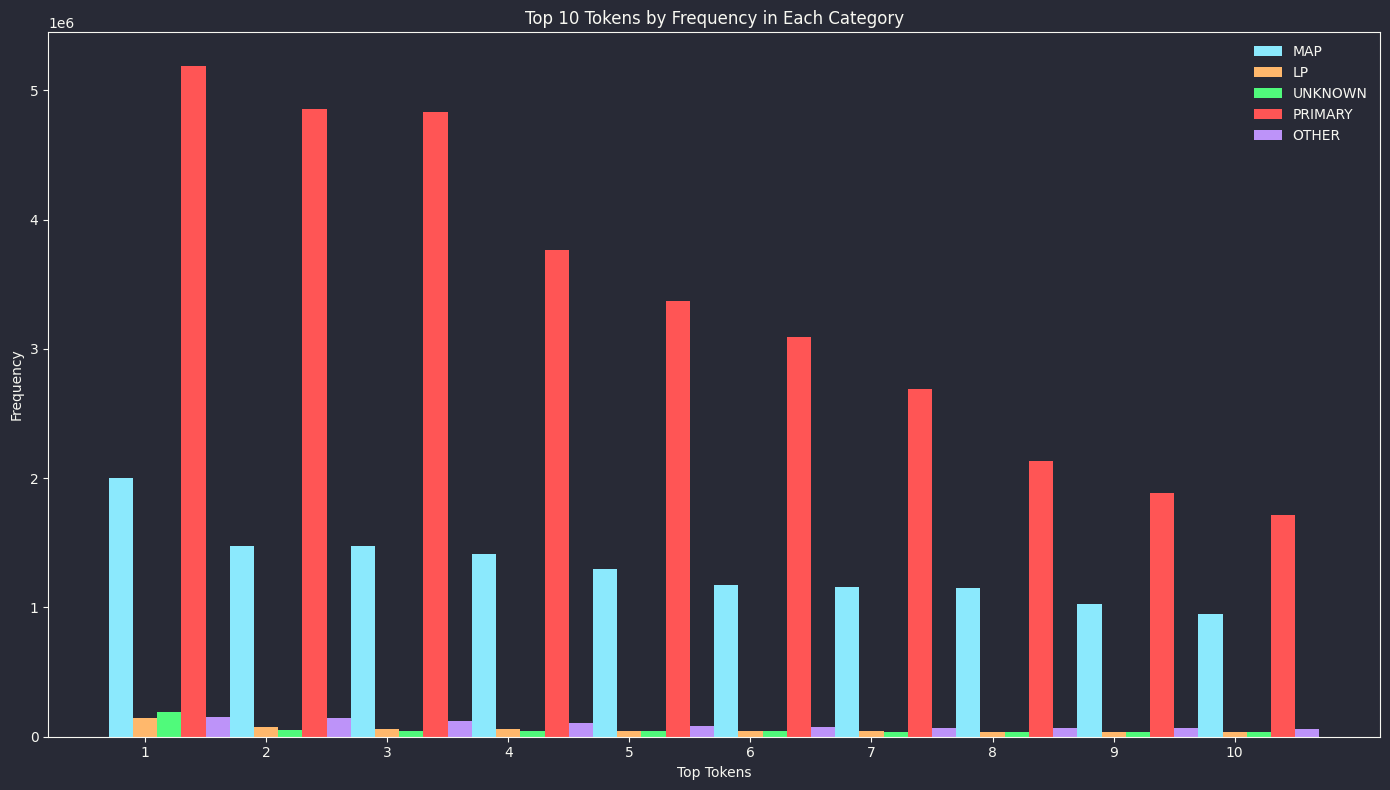

In [86]:
import numpy as np

# Prepare data for plotting
plot_data = {}
categories_list = categories.keys()
for category in categories_list:
    # Sort tokens by frequency in descending order and select the top 10
    top_tokens = sorted(categories[category].items(), key=lambda x: x[1]['frequency'], reverse=True)[:10]
    plot_data[category] = top_tokens

# Number of groups
n_groups = 10

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Set the positions and width for the bars
index = np.arange(n_groups)
bar_width = 0.2

# Plotting
for i, category in enumerate(categories_list):
    token_names = [token[0] for token in plot_data[category]]
    frequencies = [token[1]['frequency'] for token in plot_data[category]]
    
    plt.bar(index + i*bar_width, frequencies, bar_width, label=category)

# Add some final touches
plt.xlabel('Top Tokens')
plt.ylabel('Frequency')
plt.title('Top 10 Tokens by Frequency in Each Category')
plt.xticks(index + bar_width, range(1, n_groups+1))
plt.legend()

plt.tight_layout()
plt.show()

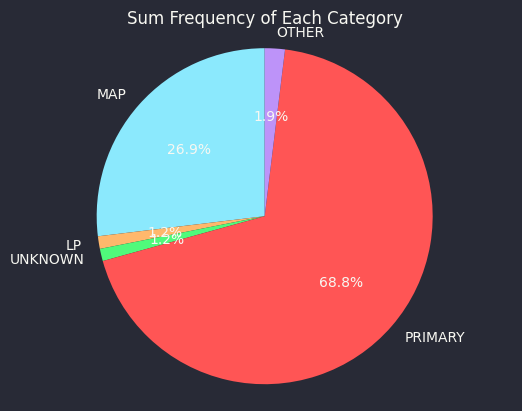

In [87]:
import matplotlib.pyplot as plt

# Calculate the sum frequency for each category
sum_frequencies = {category: sum(token[1]['frequency'] for token in tokens) for category, tokens in plot_data.items()}

# Labels and sizes for the pie chart
labels = sum_frequencies.keys()
sizes = sum_frequencies.values()

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')

plt.title('Sum Frequency of Each Category')
plt.show()

the above plots show that if we locate the protocol originator of PRIMARY, plus MAP which we already know, we would cover most of the data

# similarity score

In [ ]:
A['all_text'] = A.apply(lambda x: ' '.join(x.fillna('').replace('None', '').astype(str)), axis=1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast

# Ensure all token names are strings and handle None values
unique_token_names['token_name'] = unique_token_names['token_name'].fillna('')

# Combine unique token names and all concatenated texts from Table A
combined_texts = unique_token_names['token_name'].tolist() + A['all_text'].tolist()

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined texts to TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(combined_texts)

# Split the matrix back into token names and Table A texts
tfidf_tokens = tfidf_matrix[:len(unique_token_names)]
tfidf_A_texts = tfidf_matrix[len(unique_token_names):]

# Calculate cosine similarity
similarity_scores = cosine_similarity(tfidf_tokens, tfidf_A_texts)

# Find the index of the best matching row in A for each token and the best scores
best_matches_indices = similarity_scores.argmax(axis=1)
best_scores = similarity_scores.max(axis=1)

# Assuming a threshold for minimum acceptable similarity (e.g., 0.2)
threshold = 0.2

# Initialize the mapping dictionary
token_to_protocol_mapping = {}

# Populate the mapping dictionary
for i, token_name in enumerate(unique_token_names['token_name']):
    if best_scores[i] >= threshold:
        best_match_index = best_matches_indices[i]
        # Extract the id and name from A for the best match
        matched_id = A.iloc[best_match_index]['id']
        matched_name = A.iloc[best_match_index]['name']
        token_to_protocol_mapping[token_name] = {'id': matched_id, 'name': matched_name}
    else:
        # Note the low confidence in mapping
        token_to_protocol_mapping[token_name] = 'Low confidence in mapping; not mapped to a row in Table A.'

# Initialize two dictionaries: one for mapped tokens and one for tokens not mapped due to low confidence
mapped_tokens = {}
unmapped_tokens = {}

# Iterate through the token_to_protocol_mapping to separate mapped and unmapped tokens
for token_name, mapping_info in token_to_protocol_mapping.items():
    if isinstance(mapping_info, dict):
        # If the mapping_info is a dictionary, it means the token was successfully mapped
        mapped_tokens[token_name] = mapping_info
    else:
        # If the mapping_info is not a dictionary, it indicates low confidence in mapping
        unmapped_tokens[token_name] = mapping_info

# Now, 'mapped_tokens' contains tokens that were successfully mapped to a row in Table A,
# and 'unmapped_tokens' contains tokens that were not mapped due to low confidence.